In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
from scipy.stats import truncnorm, norm
from collections import defaultdict
import math
from shapely.ops import transform
from pyproj import Geod
import pyarrow
from datetime import datetime
import yaml

In [2]:
# Функции генерации паттернов времени и базовые функции времени созданные ранее

from data_generator.general_time import *

In [3]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [4]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [5]:
os.chdir("..")

In [6]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

In [9]:
# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

# Доп. данные для генерации транзакций

**Загрузка данных:**
- оффлайн мерчантов
- онлайн мерчантов
- девайсов клиентов и мошенников
- городов с полигонами
- городов с координатами центров
- клиентов
- фрод IP адресов
- категорий и их характеристик

In [9]:
offline_merchants = gpd.read_file("./data/cleaned_data/offline_merchants_points.gpkg")
online_merchant_ids = pd.read_csv("./data/cleaned_data/online_merchant_ids.csv").iloc[:, 0]
client_devices = pd.read_csv("./data/cleaned_data/client_devices.csv")
fraud_devices = pd.read_csv("./data/cleaned_data/fraud_devices.csv")
districts_ru = gpd.read_file("./data/cleaned_data/district_ru.gpkg")
area_centers = gpd.read_file("./data/cleaned_data/area_centers.gpkg")
clients_with_geo = gpd.read_file("./data/cleaned_data/clients_with_geo.gpkg") 
fraud_ips = gpd.read_file("./data/cleaned_data/fraud_ips.gpkg")
cat_stats_full = pd.read_csv("./data/cleaned_data/cat_stats_full.csv")

### **Функция создания пустого датафрейма для транзакций**
- модуль `data_generator.utils`

In [10]:
def create_txns_df(configs):
    """
    configs: dict. Словарь с парами 'название колонки':'тип данных'
    """
    to_df = {}
    for key in configs.keys():
        data_type = configs[key]
        to_df[key] = pd.Series(dtype=data_type)

    return pd.DataFrame(to_df)

# Функции генерации времени легальных транзакций

**Датафрейм под транзакции. Этап тестов**  
Создадим пустой датафрейм под транзакции. Будем копировать и использовать его при тестах функций

In [11]:
transactions = create_txns_df(base_cfg["txns_df"])
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


**Функция логирования для `check_min_interval_from_near_trans`**
- модуль `data_generator.legit.time.utils`

In [33]:
def log_check_min_time(client_id, txn_time, txn_unix, online, closest_txn_offline, closest_txn_online, last_txn, \
                       close_flag):
    """
    Логирует нужные данные для дебаггинга
    -------------------------------
    closest_txn_offline - pd.DataFrame. Запись о ближайшей оффлайн транзакции - может быть пустым
    closest_txn_online - pd.DataFrame. Запись о ближайшей онлайн транзакции - может быть пустым
    last_txn - pd.DataFrame. Запись о последней транзакции
    """
    if not closest_txn_offline.empty:
        closest_offline_time = closest_txn_offline.txn_time.iloc[0]
        closest_offline_unix = closest_txn_offline.unix_time.iloc[0]
    else:
        closest_offline_time = pd.NaT
        closest_offline_unix = np.nan

    if not closest_txn_online.empty:
        closest_online_time = closest_txn_online.txn_time.iloc[0]
        closest_online_unix = closest_txn_online.unix_time.iloc[0]
    else:
        closest_online_time = pd.NaT
        closest_online_unix = np.nan


    last_txn_time = last_txn.txn_time.iloc[0]
    last_txn_unix = last_txn.unix_time.iloc[0]
    last_online_flag = last_txn.online.iloc[0]
    
    log_df = pd.DataFrame({"client_id":[client_id], "txn_time":[txn_time], "txn_unix":[txn_unix], "online":[online], \
                           "closest_offline_time":[closest_offline_time], "closest_offline_unix":[closest_offline_unix], \
                            "closest_online_time":[closest_online_time], "closest_online_unix":[closest_online_unix], \
                            "last_txn_time":[last_txn_time], "last_txn_unix":[last_txn_unix], \
                           "last_online":[last_online_flag], "condition":[close_flag]})
        
    file_exists = os.path.exists("./data/generated_data/log_check_min_time.csv")
    
    if file_exists:
        log_df.to_csv("./data/generated_data/log_check_min_time.csv", mode="a", header=False)
    else:
        log_df.to_csv("./data/generated_data/log_check_min_time.csv")

## Подфункция `check_min_interval_from_near_trans` - когда есть предыдущие транзакции
- модуль `data_generator.legit.time.time`
- проверка что сгенерированное время транзакции не ближе ко времени других транзакций чем выставлено в лимитах

In [18]:
def check_min_interval_from_near_txn(client_txns, timestamp_sample, online, round_clock, legit_cfg, test=False):
    """
    Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
    то создать время на основании времени последней транзакции + установленный минимальный интервал.
    Учитывает разницу между типами транзакций: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн.
    Можно поставить свои минимальные интервалы для случаев: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн. 
    Для оффлайн-оффлайн - один фиксированный интервал.
    Для онлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
    Для оффлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью

    Также, условия в функции сделаны так, что в параметрах функции для минимальных временных разниц
    всегда должно быть такое отношение значений:
    offline_time_diff > general_diff > online_time_diff
    то есть
    оффлайн-оффлайн разница > оффлайн-онлайн разница > онлайн-онлайн разница
    -----------------------------------------------

    client_txns - датафрейм с транзакциями клиента.
    timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
    online - boolean. Онлайн или оффлайн категория
    round_clock - boolean. Круглосуточная или дневная категория.
    legit_cfg - dict. Конфиги легальных транзакция из legit.yaml           
    test - boolean. True - логировать исполнение функции в csv.
    ------------------------------------------------
    Возвращает pd.Timestamp и int unix время в секундах 
    """
    min_inter = legit_cfg["time"]["min_intervals"]
    offline_time_diff = min_inter["offline_time_diff"]
    online_time_diff = min_inter["online_time_diff"]
    online_ceil = min_inter["online_ceil"]
    general_diff = min_inter["general_diff"]
    general_ceil = min_inter["general_ceil"]

    assert offline_time_diff > general_diff, f"""offline_time_diff must not be lower than general_diff. 
                        {offline_time_diff} vs {general_diff} Check passed arguments"""
    assert offline_time_diff > online_time_diff, f"""offline_time_diff must not be lower than online_time_diff.
                        {offline_time_diff} vs {online_time_diff} Check passed arguments"""
    assert general_diff > online_time_diff, f"""general_diff must not be lower than online_time_diff.
                        {general_diff} vs {online_time_diff} Check passed arguments"""
            
    # перевод аргументов в секунды для работы с unix time
    offline_time_diff= offline_time_diff * 60
    online_time_diff= online_time_diff * 60
    online_ceil= online_ceil * 60
    general_diff = general_diff * 60
    general_ceil = general_ceil * 60

    
    timestamp_unix = timestamp_sample.unix_time.iloc[0]
    # Копия, чтобы не внести изменения в исходный датафрейм
    client_txns = client_txns.copy()
    client_txns["abs_time_proximity"] = client_txns.unix_time.sub(timestamp_unix).abs()

    # Оффлайн и онлайн транзакции
    offline_txns = client_txns.loc[client_txns.online == False]
    online_txns = client_txns.loc[client_txns.online == True]
    
    # Записи о ближайших по времени оффлайн и онлайн транзакциях
    closest_txn_offline = offline_txns.loc[offline_txns.abs_time_proximity == offline_txns.abs_time_proximity.min()]
    closest_txn_online = online_txns.loc[online_txns.abs_time_proximity == online_txns.abs_time_proximity.min()]
    
    # Разница семплированного timestamp-а с ближайшей по времени оффлайн транзакцией
    # Если такая есть
    if not closest_txn_offline.empty:
        closest_offline_diff = closest_txn_offline.abs_time_proximity.iloc[0]
        
    # Если нет предыдущийх оффлайн транзакций то назначаем минимальную разницу
    # для оффлайн транзакций, чтобы дальнейшее условие closest_offline_diff < offline_time_diff не исполнилось
    else:
        closest_offline_diff = offline_time_diff

    # Разница семплированного timestamp-а с ближайшей по времени онлайн транзакцией
    # Если такая есть
    if not closest_txn_online.empty:
        closest_online_diff = closest_txn_online.abs_time_proximity.iloc[0]
        
    # Если нет предыдущийх оффлайн транзакций то назначаем минимальную разницу
    # между онлайн и оффлайн транзакциями, чтобы дальнейшее условие closest_offline_diff < general_diff 
    # либо closest_online_diff < online_time_diff не исполнилось
    else:
        closest_online_diff = general_diff
    
    # Запись о последней транзакции
    last_txn = client_txns.loc[client_txns.unix_time == client_txns.unix_time.max()]
    # Онлайн или не онлайн последняя транзакция
    last_online_flag = last_txn.online.iloc[0]
    # unix время
    last_txn_unix = last_txn.unix_time.iloc[0]
    
    # Если, создаваемая транзакция оффлайн
    # И разница с ближайшей оффлайн транзакцией меньше допустимой
    if not online and closest_offline_diff < offline_time_diff:
        close_flag = "offline_to_offline"

    # Если оффлайн транзакция и разница с ближайшей оффлайн допустима, но не допустима с ближайшей онлайн.
    elif not online and closest_online_diff < general_diff:
        close_flag = "offline_to_online"

    # Если онлайн транзакция и разница с ближайшей оффлайн меньше допустимой
    elif online and closest_offline_diff < general_diff:
        close_flag = "online_to_offline"

    # Если онлайн транзакция и разница с ближайшей оффлайн допустима, но с ближайшей онлайн меньше допустимой
    elif online and closest_online_diff < online_time_diff:
        close_flag = "online_to_online"
        
    # Если нет транзакций ближе установленной разницы
    # Просто берем изначальный timestamp
    else:
        close_flag = "No flag"
        txn_unix = timestamp_unix
        txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если транзакция близка по времени к другой, то согласно типам транзакций
    # создаем другое время на основании времени и типа последней и текущей транзакции
    if close_flag in ["offline_to_offline", "offline_to_online"]:
        # Если последняя транзакция Онлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
        if last_online_flag:
            general_random_diff = random.randint(general_diff, general_ceil)
            txn_unix = last_txn_unix + general_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")
            
        # Если последняя транзакция Оффлайн. То добавляем допустимую разницу между оффлайн транзакциями
        elif not last_online_flag:
            txn_unix = last_txn_unix + offline_time_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если текущая транзакция онлайн и есть онлайн/оффлайн транзакция с разницей меньше допустимой
    elif close_flag in ["online_to_online", "online_to_offline"]:
        # Если последняя транзакция онлайн. То добавляем случайную разницу для онлайн транзакций в установленном диапазоне
        if last_online_flag:
            online_random_diff = random.randint(online_time_diff, online_ceil)
            txn_unix = last_txn_unix + online_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")
            
        # Если последняя транзакция Оффлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
        elif not last_online_flag:
            general_random_diff = random.randint(general_diff, general_ceil)
            txn_unix = last_txn_unix + general_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Проверка и корректировка времени, на случай если категория дневная, и время выходит за рамки этой категории
    # Если час меньше 8 и больше 21. Т.е. ограничение 08:00-21:59
    if not online and not round_clock and (txn_time.hour < 8 or txn_time.hour > 21):
        txn_time = txn_time + pd.Timedelta(10, unit="h")
        txn_unix = pd_timestamp_to_unix(txn_time)
        
    if not test:
        return txn_time, txn_unix
        
    # В тестовом режиме логируем некоторые данные в csv
    else:
        log_check_min_time(client_id=client_txns.client_id.iloc[0], txn_time=txn_time, txn_unix=txn_unix, online=online, \
                            closest_txn_offline=closest_txn_offline, closest_txn_online=closest_txn_online, last_txn=last_txn, \
                           close_flag=close_flag)
        return txn_time, txn_unix

**Тест функции `check_min_interval_from_near_trans`**

**Тест-кейсы**

- Текущая оффлайн, ближайшая ближе допустимого
    - ближайшая оффлайн, последняя онлайн
    - ближайшая оффлайн, последняя оффлайн
    - ближайшая онлайн, последняя оффлайн
    - ближайшая онлайн, последняя онлайн
- Текущая онлайн, ближайшая ближе допустимого
    - ближайшая оффлайн, последняя онлайн
    - ближайшая оффлайн, последняя оффлайн
    - ближайшая онлайн, последняя оффлайн
    - ближайшая онлайн, последняя онлайн
- разница допустима
    - ближайшая оффлайн
    - ближайшая онлайн

In [ ]:
# other_time = pd.to_datetime("2023-09-20 10:00:00", format="%Y-%m-%d %H:%M:%S")
# other_unix = pd_timestamp_to_unix(other_time)
# other_time, other_unix

In [ ]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np
os.chdir("..")
# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
from data_generator.general_time import *
from data_generator.utils import create_txns_df
from data_generator.legit.time.time import check_min_interval_from_near_txn

transactions = create_txns_df(base_cfg["txns_df"])

In [10]:
# nearest txn time

nearest_time = pd.to_datetime("2025-01-31 08:14:00", format="%Y-%m-%d %H:%M:%S")
nearest_unix = pd_timestamp_to_unix(nearest_time)
print(f"nearest: {nearest_time}, {nearest_unix}")

# last txn time

last_time = pd.to_datetime("2025-01-31 09:16:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)
print(f"last: {last_time}, {last_unix}")

# current txn time

timstamp_check_min = pd.to_datetime("2025-01-31 08:19:00", format="%Y-%m-%d %H:%M:%S")
timstamp_check_min_unix = pd_timestamp_to_unix(timstamp_check_min)
timestamp_sample_check_min = pd.DataFrame([{"timestamp":timstamp_check_min, "unix_time":timstamp_check_min_unix}])
timestamp_sample_check_min

nearest: 2025-01-31 08:14:00, 1738311240
last: 2025-01-31 09:16:00, 1738314960


,timestamp,unix_time
0,2025-01-31 08:19:00,1738311540


**txns dataframe**

In [11]:
trans_time_test = transactions.copy().loc[:, ['client_id', 'txn_time', 'unix_time','online','account', \
                                                                  'is_fraud', 'is_suspicious']]

**previous txns times and online flag**

In [12]:
# Выставить online флаги для nearest и last в соответствии с тест-кейсом. Other можно пренебречь

# trans_time_test.loc[0, ["txn_time","unix_time", "online"]] = other_time, other_unix, False
trans_time_test.loc[1, ["client_id", "txn_time","unix_time", "online"]] = 28, nearest_time, nearest_unix, False
trans_time_test.loc[2, ["client_id", "txn_time","unix_time", "online"]] = 28, last_time, last_unix, True
trans_time_test

,client_id,txn_time,unix_time,online,account,is_fraud,is_suspicious
1,28.0,2025-01-31 08:14:00,1.738311e+09,False,NaN,NaN,NaN
2,28.0,2025-01-31 09:16:00,1.738315e+09,True,NaN,NaN,NaN


**Запуск функции**

In [13]:
# Выставить в функции аргумент online в соответсвии с тест-кейсом
# True - создаваемая транзакция - онлайн. False - оффлайн
txn_time, txn_unix = check_min_interval_from_near_txn(client_txns=trans_time_test, timestamp_sample=timestamp_sample_check_min, online=True, \
                                                        round_clock=True, legit_cfg=legit_cfg, test=False)

# Запись сгенерированной транзакции в датафрейм: время, online флаг
trans_time_test.loc[3, ["client_id", "txn_time","unix_time", "online"]] = 28, txn_time, txn_unix, True
trans_time_test = trans_time_test.sort_values("txn_time")

# Расчет времени между транзакциями в минутах
trans_time_test["abs_time_proximity"] = trans_time_test.unix_time.sub(trans_time_test.unix_time.shift(1)).div(60)
trans_time_test

,client_id,txn_time,unix_time,online,account,is_fraud,is_suspicious,abs_time_proximity
1,28.0,2025-01-31 08:14:00,1.738311e+09,False,NaN,NaN,NaN,NaN
2,28.0,2025-01-31 09:16:00,1.738315e+09,True,NaN,NaN,NaN,62.000000
3,28.0,2025-01-31 09:44:02,1.738317e+09,True,NaN,NaN,NaN,28.033333


# Функция `get_legit_txn_time`
- генерация времени легальных транзакций

In [ ]:
trans_df: pd.DataFrame. Транзакции текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
time_weights: pd.DataFrame. Веса часов в периоде времени
timestamps: pd.DataFrame. timestamps для генерации времени.
timestamps_1st_month: pd.DataFrame. сабсет timestamps отфильтрованный по первому месяцу и, 
                       если применимо, году. Чтобы генерировать первые транзакции
legit_cfg: dict. Конфиги легальных транзакция из legit.yaml  
round_clock: boolean. Круглосуточная или дневная категория.
online: boolean. Онлайн или оффлайн покупка. True or False

In [64]:
def get_legit_txn_time(trans_df, time_weights, timestamps, timestamps_1st_month, \
                       legit_cfg, round_clock, online=None):
    """
    Генерация времени для легальной транзакции
    ------------------------------------------
    trans_df: pd.DataFrame. Транзакции текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
    time_weights: pd.DataFrame. Веса часов в периоде времени
    timestamps: pd.DataFrame. timestamps для генерации времени.
    timestamps_1st_month: pd.DataFrame. сабсет timestamps отфильтрованный по первому месяцу и, 
                          если применимо, году. Чтобы генерировать первые транзакции.
    legit_cfg: dict. Конфиги легальных транзакция из legit.yaml  
    round_clock: bool. Круглосуточная или дневная категория.
    online: bool. Онлайн или оффлайн покупка. True or False
    -------------------------------------------
    Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
    """
    
    # Время последней транзакции клиента. pd.Timestamp и unix в секундах
    last_txn_time = trans_df.txn_time.max()
    last_txn_unix = trans_df.unix_time.max()
    
    # Если нет никакой предыдущей транзакции т.е. нет последнего времени совсем
    if last_txn_time is pd.NaT:
        # время транзакции в виде timestamp и unix time.
        return sample_time_for_trans(timestamps=timestamps_1st_month, time_weights=time_weights)

    # Если есть предыдущая транзакция

    # берем случайный час передав веса часов для соответсвующейго временного паттерна
    txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
    # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
    # Дальше будем обрабатывать этот timestamp в некоторых случаях
    timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
    timestamp_sample = timestamps_subset.sample(n=1, replace=True)

    # Если текущая транзакция - оффлайн.
    if not online:
        # check_min_interval_from_near_txn проверит ближайшие к timestamp_sample по времени транзакции в соответствии с установленными
        # интервалами и если время до ближайшей транзакции меньше допустимогшо, то создаст другой timestamp
        # Если интервал допустимый, то вернет исходный timestamp
        txn_time, txn_unix = check_min_interval_from_near_txn(client_txns=trans_df, timestamp_sample=timestamp_sample, online=online, \
                                                                round_clock=round_clock, legit_cfg=legit_cfg)
        return txn_time, txn_unix

    # То же самое, но если текущая транзакция - онлайн
    elif online:
        txn_time, txn_unix = check_min_interval_from_near_txn(client_txns=trans_df, timestamp_sample=timestamp_sample, online=online, \
                                                                round_clock=round_clock, legit_cfg=legit_cfg)
        return txn_time, txn_unix

# Функции для генерации остальных данных транзакции   
Вспомогательные и самостоятельные

## Функция генератор локации и мерчанта транзакции `get_txn_location_and_merchant`

In [29]:
def get_txn_location_and_merchant(online, merchants_df, category_name, client_info, online_merchant_ids):
    """
    Возвращает id мерчанта, геолокацию транзакции: для оффлайна это координаты и город мерчанта, для онлайна координаты по IP и город по IP.
    Возвращает IP адрес с которого совершена транзакция если это онлайн покупка.
    --------------------------------------------------------------------
    client_info - namedtuple, полученная в результате итерации через датафрейм с информацией о клиентах 
                  с помощью .itertuples()
    category_name - Название категории покупки
    merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента если это легальные транзакции
    online_merchant_ids - id для онлайн мерчантов
    """

    # Комментарий себе на будущее. Если универсализировать это под фрод. То возможно надо только ip через доп. блок if-else определить
    # И соотвественно для фрод оффлайн передавать merchants_df без города клиента.

    
    # Если онлайн покупка
    if online:
        merchant_id = online_merchant_ids.sample(n=1).iloc[0]
        # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
        trans_lat = client_info.lat
        trans_lon = client_info.lon
        # Также т.к. это не фрод, то просто берется home_ip и город из данных клиента.
        trans_ip = client_info.home_ip
        trans_city = client_info.area
        
    # Если оффлайн покупка    
    else:
        # Семплируется мерчант
        merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
        # Берется его id, и координаты, как координаты транзакции
        merchant_id = merchant["merchant_id"].iloc[0]
        trans_lat = merchant["merchant_lat"].iloc[0]
        trans_lon = merchant["merchant_lon"].iloc[0]
        trans_ip = "not applicable"
        trans_city = merchant["area"].iloc[0]

    return merchant_id, trans_lat, trans_lon, trans_ip, trans_city

**Сабсет данных для тестов**

In [30]:
for row in clients_with_geo[clients_with_geo.client_id == 32].itertuples():
    one_client_info = row
one_client_info

Pandas(Index=31, client_id=32, district_id=52, birth_date='1980-07-28', sex='male', region='Челябинская', area='Челябинск', timezone='UTC+5', lat=55.1603659, lon=61.4007858, population=1130273, home_ip='2.60.0.32', geometry=<MULTIPOLYGON (((61.144 55.054, 61.144 55.054, 61.144 55.054, 61.144 55.054,...>)

In [31]:
offline_merchants_test_one_trans = offline_merchants[offline_merchants["area"] == one_client_info.area]
offline_merchants_test_one_trans.head(2)

,district_code,region,area,timezone,population,clients,category,avg_amt,amt_std,cat_count,merchant_id,merchant_lat,merchant_lon,geometry
88,52,Челябинская,Челябинск,UTC+5,1130273,73,gas_transport,63.577001,15.828399,56370,89.0,55.084332,61.415330,POINT (61.41533 55.08433)
89,52,Челябинская,Челябинск,UTC+5,1130273,73,grocery_pos,115.885327,51.552330,52553,90.0,55.183888,61.282977,POINT (61.28298 55.18389)


In [32]:
# Небольшой тест get_txn_location_and_merchant

get_txn_location_and_merchant(online=False, merchants_df=offline_merchants_test_one_trans, category_name="gas_transport", \
                              client_info=one_client_info, online_merchant_ids=online_merchant_ids)

(np.float64(1783.0),
 np.float64(55.08015042043183),
 np.float64(61.38186522545279),
 'not applicable',
 'Челябинск')

## Функция сбора данных транзакции в словарь `build_transaction`  
>Оставить в этом ноутбуке, но вынести в какой-то общий модуль. Напр. `utils`

In [34]:
def build_transaction(client_id, txn_time, txn_unix, amount, type, channel, category_name, online, merchant_id, \
                      trans_city, trans_lat, trans_lon, trans_ip, device_id, account, is_fraud, is_suspicious, \
                      status, rule):
    """
    Собирает словарь с данными транзакции
    """

    txn_dict = {
                "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": amount, "type": type,
                "channel": channel, "category": category_name, "online": online, "merchant_id": merchant_id,
                "trans_city":trans_city, "trans_lat": trans_lat, "trans_lon": trans_lon, "trans_ip":trans_ip,
                "device_id": device_id, "account": account, "is_fraud": is_fraud, "is_suspicious":is_suspicious, "status":status,
                "rule":rule
                }

    return txn_dict

In [37]:
pos_txn_dict = {
                    "client_id": 1, "txn_time": 1, "txn_unix":1, "amount": round(4, 2), "type": "purchase",
                    "channel": "POS", "category_name": 1, "online": 1, "merchant_id": 1, "device_id":78,
                    "trans_city":1, "trans_lat": 1, "trans_lon": 1,"trans_ip":"not applicable",
                    "account": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
                    "rule":"not applicable"
                    }

In [38]:
build_transaction(**pos_txn_dict)

{'client_id': 1,
 'txn_time': 1,
 'unix_time': 1,
 'amount': 4,
 'type': 'purchase',
 'channel': 'POS',
 'category': 1,
 'online': 1,
 'merchant_id': 1,
 'trans_city': 1,
 'trans_lat': 1,
 'trans_lon': 1,
 'trans_ip': 'not applicable',
 'device_id': 78,
 'account': nan,
 'is_fraud': False,
 'is_suspicious': False,
 'status': 'approved',
 'rule': 'not applicable'}

# Функция генератор одной легальной транзакции `generate_one_legit_txn`

In [40]:
def generate_one_legit_txn(client_info, client_trans_df, client_device_ids, category, merchants_df, online_merchant_ids, timestamps, \
                             timestamps_1st_month, time_weights_dict):
    """
    Генерация одной легальной транзакции покупки для клиента
    ------------------------------------------------
    client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
    client_trans_df - датафрейм с транзакциями клиента.
    client_device_ids - pd.Series. id девайсов клиента.
    category - датафрейм в одну запись с категорией и её характеристиками
    merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента т.к. это легальные транзакции
    online_merchant_ids - id для онлайн мерчантов
    time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
    """

    # Записываем данные клиента в переменные
    client_id = client_info.client_id
    client_area = client_info.area
    client_area_lat = client_info.lat
    client_area_lon = client_info.lon
    client_ip = client_info.home_ip
    
    
    category_name = category["category"].iloc[0]
    round_clock = category["round_clock"].iloc[0]
    online = category["online"].iloc[0]
    # средняя сумма для этой категории
    amt_mean = category["avg_amt"].iloc[0]
    # стандартное отклонение сумм для этой категории
    amt_std = category["amt_std"].iloc[0]
    
    # случайно сгенерированная сумма транзакции, но не менее 1
    amount = max(1, np.random.normal(amt_mean, amt_std))

    
    # 1. Offline_24h_Legit - круглосуточные оффлайн покупки
    if not online and round_clock:
        weights_key = "Offline_24h_Legit"
        channel = "POS"
        device_id = pd.NA
        
    # 2. Online_Legit - Онлайн покупки
    elif online:
        weights_key = "Online_Legit"
        # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
        trans_lat = client_area_lat
        trans_lon = client_area_lon
        channel = "ecom"
        device_id = client_device_ids.sample(n=1).iloc[0]
        
    # 3. Offline_Day_Legit - Оффлайн покупки. Дневные категории.
    elif not online and not round_clock:
        weights_key = "Offline_Day_Legit"
        channel = "POS"
        device_id = pd.NA
        
    # Генерация мерчанта, координат транзакции. И если это онлайн, то IP адреса с которого сделана транзакция
    merchant_id, trans_lat, trans_lon, trans_ip, trans_city = get_txn_location_and_merchant(online, merchants_df, category_name, \
                                                                                            client_info, online_merchant_ids)
    
    time_weights = time_weights_dict[weights_key]["weights"]
    
    # Генерация времени транзакции
    txn_time, txn_unix = get_legit_txn_time(trans_df=client_trans_df, time_weights=time_weights, \
                                                timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
                                                round_clock=round_clock, online=online)
    # Статичные значения для данной функции.
    status = "approved"
    type = "purchase"
    is_fraud = False
    is_suspicious = False
    account = pd.NA
    rule = "not applicable"
    
    # Возвращаем словарь со всеми данными сгенерированной транзакции
    return build_transaction(client_id=client_id, txn_time=txn_time, txn_unix=txn_unix, amount=amount, type=type, channel=channel, \
                             category_name=category_name, online=online, merchant_id=merchant_id, trans_city=trans_city, \
                             trans_lat=trans_lat, trans_lon=trans_lon, trans_ip=trans_ip, device_id=device_id, account=account, \
                             is_fraud=is_fraud, is_suspicious=is_suspicious, status=status, rule=rule)

**Тестирование функции `generate_one_legit_trans`**

In [41]:
def get_category(cat_stats_full, random_cat=False, condition=1):
    """
    Вернет запись датафрейма с информацией об одной из 3-х категорий
    Категории выбраны под 3 временных паттерна легальных транзакций
    ---------------------------------------------------------------
    cat_stats_full - pd.DataFrame с категориями и из характеристиками
    random_cat - случайно ли выбрать из 3-х категорий. Если True - выберет с равной вероятностью.
                 Если False, то надо передать номер категории в condition
    condition - номер категории при неслучайном выборе. По умолчанию 1
                1 - Offline_24h_Legit - круглосуточные оффлайн покупки
                2 - Online_Legit - Онлайн покупки
                3 - Offline_Day_Legit - Дневные оффлайн покупки
    """
    
    if random_cat:
        condition = random.randint(1,3)
    
    # Условие 1. Offline_24h_Legit - круглосуточные оффлайн покупки
    if condition == 1:
        category = cat_stats_full.query("category == 'gas_transport'")
    
    # Условие 2. Online_Legit - Онлайн покупки
    elif condition == 2:
        category = cat_stats_full.query("category == 'shopping_net'")
    
    # Условие 3. Offline_Day_Legit - Дневные оффлайн покупки
    elif condition == 3:
        category = cat_stats_full.query("category == 'home'")


    return category

**Проверка нескольких кейсов**
1. Из предыдущих есть только **онлайн** транзакции и текущая категория это **оффлайн круглосуточная**
2. Из предыдущих есть только **онлайн** транзакции и текущая категория это **оффлайн дневная**
3. Из предыдущих есть только **оффлайн** транзакции и текущая категория это **онлайн**
4. Из предыдущих есть **оффлайн и  онлайн** транзакции и текущая категория это **оффлайн** круглосуточная
5. Из предыдущих есть **оффлайн и  онлайн** транзакции и текущая категория это **онлайн**

In [42]:
# маппинг типа распределения и аргументов для функции gen_weights_for_time

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [43]:
time_weights_dict_one_trans = get_all_time_patterns(time_weight_args)

In [44]:
timestamps_one_trans_test = create_timestamps_range_df(start="2025-01-01", end="2025-02-28")

In [45]:
timestamps_one_trans_test_1st_mon = timestamps_one_trans_test.loc[timestamps_one_trans_test.timestamp.dt.month == 1]

In [46]:
for row in clients_with_geo[clients_with_geo.client_id == 33].itertuples():
    one_client_info = row
one_client_info

Pandas(Index=32, client_id=33, district_id=73, birth_date='1948-12-04', sex='female', region='Оренбургская', area='Оренбург', timezone='UTC+5', lat=51.7875191, lon=55.1017379, population=570329, home_ip='2.60.0.33', geometry=<MULTIPOLYGON (((55.019 51.79, 55.019 51.791, 55.023 51.793, 55.026 51.8, 55...>)

In [47]:
offline_merchants_test_one_trans = offline_merchants[offline_merchants["area"] == one_client_info.area]
offline_merchants_test_one_trans.head(2)

,district_code,region,area,timezone,population,clients,category,avg_amt,amt_std,cat_count,merchant_id,merchant_lat,merchant_lon,geometry
297,73,Оренбургская,Оренбург,UTC+5,570329,60,health_fitness,53.867432,47.965251,36674,298.0,51.758655,55.108108,POINT (55.10811 51.75865)
298,73,Оренбургская,Оренбург,UTC+5,570329,60,personal_care,48.233021,49.410941,39327,299.0,51.872969,55.175772,POINT (55.17577 51.87297)


In [48]:
client_device_ids_test_one = client_devices.loc[client_devices.client_id == one_client_info.client_id, "device_id"]
client_device_ids_test_one

32      58
5394    59
Name: device_id, dtype: int64

In [65]:
client_trans_df = transactions.copy()
client_trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


In [62]:
category_test_one_trans = get_category(cat_stats_full, condition=2)
category_test_one_trans

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
5,shopping_net,834.816532,2372.197581,41779,True,0.07518,506,0.012111,True


In [58]:
one_trans_test = generate_one_legit_trans(client_info=one_client_info, client_trans_df=client_trans_df, client_device_ids=client_device_ids_test_one, \
                                          category=category_test_one_trans, merchants_df=offline_merchants_test_one_trans, \
                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps_one_trans_test, \
                                     timestamps_1st_month=timestamps_one_trans_test_1st_mon, time_weights_dict=time_weights_dict_one_trans)
    
one_trans_test_df = pd.DataFrame([one_trans_test])
client_trans_df = pd.concat([client_trans_df, one_trans_test_df], ignore_index=True).sort_values("unix_time").reset_index(drop=True)
client_trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,33,2025-01-05 20:13:00,1736107980,2418.906416,purchase,ecom,shopping_net,True,6903,Оренбург,51.787519,55.101738,2.60.0.33,58,<NA>,False,False,approved,not applicable


**Проверка с рандомизацией условий**<br>
Просто прогон на большом количестве попыток, чтобы проверить будет ли падать с ошибкой

In [66]:
# 1. есть предыдущие транзакции/нет транзакций
# 2. случайная категория и, соотвественно, ее характеристики - онлайн/оффлайн, круглосуточная/дневная и т.д.

empty_vs_not = {"empty":0, "not_empty":0}

# 30 раз с нуля будем создавать 100 транзакций
for _ in range(30):
    empty_trans = random.randint(0, 1)
    client_trans_df = transactions.copy()
    
    for _ in range(100):
        
        # Условие - Пустой датафрейм перед генерацией транзакции
        if empty_trans:
            client_trans_df = transactions.copy()
            empty_vs_not["empty"] += 1
        # Если нет, просто пишем в счетчик, что условие не исполнено и датафрейм не пустой.
        else:
            empty_vs_not["not_empty"] += 1
            
        # Случайная категория
        category_test_one_trans = cat_stats_full.sample(1)
        
        one_trans_test = generate_one_legit_trans(client_info=one_client_info, client_trans_df=client_trans_df, \
                                                  client_device_ids=client_device_ids_test_one, \
                                                  category=category_test_one_trans, merchants_df=offline_merchants_test_one_trans, \
                                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps_one_trans_test, \
                                     timestamps_1st_month=timestamps_one_trans_test_1st_mon, time_weights_dict=time_weights_dict_one_trans)

        one_trans_test_df = pd.DataFrame([one_trans_test])
        client_trans_df = pd.concat([client_trans_df, one_trans_test_df], ignore_index=True)

# Проверка что условие empty_trans было исполнено в обоих вариантах
(empty_vs_not["empty"], empty_vs_not["not_empty"])

(1600, 1400)

### Функция генерации числа транзакций по нормальному распределению с ограничениями через `truncnorm`

In [71]:
def gen_trans_number_norm(avg_num, num_std, low_bound=1, up_bound=120):
    """
    Возвращает целое число по нормальному распределению.
    Число ограничено выставленными лимитами.
    ----------------------------------------
    avg_num - среднее число транзакций
    num_std - стандартное отклонение числа транзакций
    low_bound - минимальное возможное число транзакций
    up_bound - максимальное возможное число транзакций
    size - размер выборки
    """
    
    # Вернет float в виде np.ndarray
    random_float = truncnorm.rvs(a=(low_bound - avg_num) / num_std, b=(up_bound - avg_num) / num_std, \
                                 loc=avg_num, scale=num_std, size=1)

    # Преобразуем float в int и извлекаем из массива
    return random_float.astype(int)[0]

**Тест `gen_trans_number_norm`**

In [136]:
trans_num_test = []

for _ in range(1000):
    one_sample_test = gen_trans_number_norm(avg_num=50, num_std=40, low_bound=1, up_bound=120)
    trans_num_test.append(one_sample_test)
min(trans_num_test), max(trans_num_test), np.mean(trans_num_test)

(np.int64(1), np.int64(119), np.float64(53.02))

# Функция генерации нескольких легальных транзакций - `Рабочая версия`

In [74]:
def gen_multiple_legit_trans(clients_df, trans_df, client_devices, offline_merchants, timestamps, timestamps_1st_month, categories, \
                             online_merchant_ids, time_weights_dict, avg_trans_num=50, trans_num_std=10, ignore_index=True):
    """
    Генерирует несколько транзакций для каждого клиента ориентируясь на существующие транзакции если они есть.
    Количество берется по нормальному распределению с указанными средним с стандартным отклонением.
    Ограничение забито в функцию gen_trans_number_norm: от 1 до 120 транзакций.
    ---------------------------------------------------
    clients_df - pd.DataFrame. Уникальные клиенты для кого нужно генерировать транзакции
    trans_df - pd.DataFrame. Все транзакции на данный момент. Может быть пустым.
    client_devices - pd.DataFrame. Девайсы клиентов, нужны для онлайн транзакций
    offline_merchants - pd.DataFrame. Оффлайн мерчанты с их данными: город, координаты, id
    timestamps - pd.DataFrame. Заданный диапазон timestamp-ов из которого будет случайно браться время транзакций.
    timestamps_1st_month - pd.DataFrame. Отфильтрованный по первому месяцу timestamps. Для времени первой транзакции
    categories - pd.DataFrame. Категории покупок и из характеристики: ср. цена, отклонение цены, вероятность этой категории, онлайн/оффлайн и др.
    online_merchant_ids - pd.Series. id онлайн мерчантов для онлайн покупок.
    time_weights_dict - dict. Содержит в себе pd.DataFrame-мы с распределениями времени - временными паттернами для своих типов категорий.
    avg_trans_num - int. Среднее число транзакций на клиента. Для рандомизации кол-ва транзакций на клиента.
    trans_num_std - int. Стандартное отклонение числа транзакций на клиента.
    ignore_index - boolean. Сбросить ли индекс при конкатенации датафреймов в финальный датафрейм с транзакциями всех клиентов
    """
    # Сюда собираются все созданные датафреймы с транзакциями клиентов для объединения в конце через pd.concat
    all_clients_trans = [trans_df]
    
    for client_info in clients_df.itertuples():
    	
        # случайное кол-во транзакций на клиента взятое из нормального распределения. Но не меньше 1 и не более 120
        trans_number = gen_trans_number_norm(avg_num=avg_trans_num, num_std=trans_num_std)
        merchants_from_area = offline_merchants[offline_merchants["area"] == client_info.area]
        client_transactions = trans_df.loc[trans_df.client_id == client_info.client_id]
        
        # id девайсов клиента для онлайн транзакций
        client_device_ids = client_devices.loc[client_devices.client_id == client_info.client_id, "device_id"]
        
        # Сюда будем собирать сгенрированные транзакции в виде словарей.
        pos_txns = []

        for _ in range(trans_number):
            # семплирование категории для транзакции
            category = categories.sample(1, replace=True, weights=categories.share)

            # генерация одной транзакции
            one_trans = generate_one_legit_trans(client_info=client_info, client_trans_df=client_transactions, category=category, \
                                                    client_device_ids=client_device_ids, merchants_df=merchants_from_area, \
                                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps, \
                                                 timestamps_1st_month=timestamps_1st_month, time_weights_dict=time_weights_dict)
            pos_txns.append(one_trans)
            one_trans_df = pd.DataFrame([one_trans])
            # Добавляем созданную транзакцию к транзакциям клиента, т.к. иногда при генерации других транзакций
            # нужно знать уже созданные транзакции
            client_transactions = pd.concat([client_transactions, one_trans_df], ignore_index=True)
            
        client_new_trans = pd.DataFrame(pos_txns)
        all_clients_trans.append(client_new_trans)
        
    trans_df = pd.concat(all_clients_trans, ignore_index=ignore_index)
    return trans_df

In [75]:
# Генерация датафрейма с timestamp-ами для семплирования времени транзакций

timestamps_multi_legit = create_timestamps_range_df(start="2025-01-01 00:00:00", end="2025-01-31 23:59:59", \
                                        format="%Y-%m-%d %H:%M:%S", freq="min")

In [76]:
timestamps_multi_legit.iloc[np.r_[0:3,-3:0]]

,timestamp,hour,unix_time
0,2025-01-01 00:00:00,0,1735689600
1,2025-01-01 00:01:00,0,1735689660
2,2025-01-01 00:02:00,0,1735689720
44637,2025-01-31 23:57:00,23,1738367820
44638,2025-01-31 23:58:00,23,1738367880
44639,2025-01-31 23:59:00,23,1738367940


In [77]:
# Сабсет датафрейма с timestamp-ами за первый месяц периода. Для первых транзакций

timestamps_1st_month = timestamps_multi_legit[timestamps_multi_legit.timestamp.dt.month == timestamps_multi_legit.timestamp.dt.month.min()]
timestamps_1st_month.iloc[np.r_[0:3,-3:0]]

,timestamp,hour,unix_time
0,2025-01-01 00:00:00,0,1735689600
1,2025-01-01 00:01:00,0,1735689660
2,2025-01-01 00:02:00,0,1735689720
44637,2025-01-31 23:57:00,23,1738367820
44638,2025-01-31 23:58:00,23,1738367880
44639,2025-01-31 23:59:00,23,1738367940


**Тестирование функции `gen_multiple_legit_trans`**

Создадим пустой датафрейм для записи транзакций в него

In [78]:
transactions = pd.DataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "txn_time": pd.Series(dtype="datetime64[ns]"),
             "unix_time":pd.Series(dtype="int64"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="bool"),
            "merchant_id":pd.Series(dtype="int64"),
             "trans_city":pd.Series(dtype="string"),
            "trans_lat":pd.Series(dtype="float64"),
             "trans_lon":pd.Series(dtype="float64"),
            "trans_ip":pd.Series(dtype="string"),
             "device_id":pd.Series(dtype="int64"),
             "account": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="bool"),
             "is_suspicious": pd.Series(dtype="bool"),
            "status":pd.Series(dtype="string"),
            "rule":pd.Series(dtype="string")})
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


In [79]:
# скопируем пустой датафрейм под транзакции для тестов
trans_for_test_multi = transactions.copy()
trans_for_test_multi

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


In [80]:
client_ids = list(range(1,422))
clients_with_geo_subset = clients_with_geo.query("client_id in @client_ids")

In [81]:
print(clients_with_geo_subset.shape)
clients_with_geo_subset.head()

(401, 12)


,client_id,district_id,birth_date,sex,region,area,timezone,lat,lon,population,home_ip,geometry
0,1,18,1970-12-13,female,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,2.60.0.1,"MULTIPOLYGON (((39.53667 54.6385, 39.53677 54...."
1,2,1,1945-02-04,male,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.2,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
2,3,1,1940-10-09,female,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.3,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
3,4,5,1956-12-01,male,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.4,"MULTIPOLYGON (((39.47099 47.20487, 39.48381 47..."
4,5,5,1960-07-03,female,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.5,"MULTIPOLYGON (((39.47099 47.20487, 39.48381 47..."


In [82]:
# Аргументы для функции генерации паттернов времени.

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [83]:
time_weights_dict_multi_leg = get_all_time_patterns(time_weight_args)

In [84]:
%%time
multi_legit_trans_test_orig = gen_multiple_legit_trans(clients_df=clients_with_geo_subset, trans_df=trans_for_test_multi, \
                                                  client_devices=client_devices, offline_merchants=offline_merchants, \
                                                  timestamps=timestamps_multi_legit, timestamps_1st_month=timestamps_1st_month, \
                                                 categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
                                                  time_weights_dict=time_weights_dict_multi_leg, ignore_index=False)

CPU times: total: 2min 37s
Wall time: 2min 40s


In [85]:
multi_legit_trans_test = multi_legit_trans_test_orig.sort_values("unix_time").copy() #.reset_index(drop=True)
print(multi_legit_trans_test.shape)
multi_legit_trans_test.head()

(19811, 19)


,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
38,375,2025-01-01 01:18:00,1735694280,1463.805130,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,<NA>,False,False,approved,not applicable
7,144,2025-01-01 01:47:00,1735696020,1.000000,purchase,POS,food_dining,False,2505.0,Таганрог,47.241043,38.831282,not applicable,<NA>,<NA>,False,False,approved,not applicable
43,356,2025-01-01 02:52:00,1735699920,1.000000,purchase,ecom,shopping_net,True,6828.0,Москва,55.753879,37.620373,2.60.1.81,613,<NA>,False,False,approved,not applicable
27,335,2025-01-01 04:09:00,1735704540,3716.866118,purchase,ecom,misc_net,True,6900.0,Оренбург,51.787519,55.101738,2.60.1.60,575,<NA>,False,False,approved,not applicable
7,148,2025-01-01 05:17:00,1735708620,2181.456788,purchase,ecom,shopping_net,True,6827.0,Липецк,52.610303,39.594627,2.60.0.139,256,<NA>,False,False,approved,not applicable


In [86]:
# Минимальное и максимаольное кол-во сгенерированных транзакций на клиента

multi_legit_trans_test.groupby("client_id").agg({"txn_time":"count"}).rename(columns={"txn_time":"txns_count"}).agg(["min","max"])

,txns_count
min,20
max,75


In [87]:
# Добавим колонку со временем предыдущей транзакции каждого клиента и online статус предыдущей транзакции: True или False

for client in clients_with_geo_subset.itertuples():
    client_id = client.client_id
    multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "prev_txn_unix"] \
                = multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "unix_time"].shift(1)
    multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "prev_online"] \
                = multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "online"].shift(1)

In [88]:
# Разница между предыдущей транзакцией клиента в минутах

multi_legit_trans_test["prev_time_diff_m"] = multi_legit_trans_test.unix_time.sub(multi_legit_trans_test.prev_txn_unix).div(60)
multi_legit_trans_test.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m
38,375,2025-01-01 01:18:00,1735694280,1463.805130,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,<NA>,False,False,approved,not applicable,NaN,NaN,NaN
7,144,2025-01-01 01:47:00,1735696020,1.000000,purchase,POS,food_dining,False,2505.0,Таганрог,47.241043,38.831282,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN
43,356,2025-01-01 02:52:00,1735699920,1.000000,purchase,ecom,shopping_net,True,6828.0,Москва,55.753879,37.620373,2.60.1.81,613,<NA>,False,False,approved,not applicable,NaN,NaN,NaN
27,335,2025-01-01 04:09:00,1735704540,3716.866118,purchase,ecom,misc_net,True,6900.0,Оренбург,51.787519,55.101738,2.60.1.60,575,<NA>,False,False,approved,not applicable,NaN,NaN,NaN
7,148,2025-01-01 05:17:00,1735708620,2181.456788,purchase,ecom,shopping_net,True,6827.0,Липецк,52.610303,39.594627,2.60.0.139,256,<NA>,False,False,approved,not applicable,NaN,NaN,NaN


In [89]:
# проверим последовательность расчета разницы времени между транзакциями на паре клиентов

multi_legit_2_clients = multi_legit_trans_test.query("client_id in [28, 64]")[["client_id", "txn_time", "unix_time",  \
                                                                        "prev_txn_unix", "prev_time_diff_m", "prev_online"]] \
                                        .sort_values(["client_id", "unix_time"]).groupby("client_id", as_index=False).head(5) \
                                        .fillna({"prev_txn_unix":0, "prev_time_diff_m":0}).astype({"prev_txn_unix":"int64"})
multi_legit_2_clients["prev_time_diff_m"] = pd.to_timedelta(multi_legit_2_clients["prev_time_diff_m"], unit="m")
multi_legit_2_clients

,client_id,txn_time,unix_time,prev_txn_unix,prev_time_diff_m,prev_online
1,28,2025-01-01 18:58:00,1735757880,0,0 days 00:00:00,NaN
30,28,2025-01-03 19:59:00,1735934340,1735757880,2 days 01:01:00,False
23,28,2025-01-04 20:12:00,1736021520,1735934340,1 days 00:13:00,False
18,28,2025-01-06 18:38:00,1736188680,1736021520,1 days 22:26:00,False
4,28,2025-01-06 21:30:00,1736199000,1736188680,0 days 02:52:00,False
14,64,2025-01-01 14:21:00,1735741260,0,0 days 00:00:00,NaN
43,64,2025-01-01 17:56:00,1735754160,1735741260,0 days 03:35:00,False
16,64,2025-01-02 13:57:00,1735826220,1735754160,0 days 20:01:00,False
57,64,2025-01-03 09:32:00,1735896720,1735826220,0 days 19:35:00,False
58,64,2025-01-03 17:59:00,1735927140,1735896720,0 days 08:27:00,False


In [90]:
# Проверим минимальную И максимальную разницу во времени между транзакциями

multi_legit_trans_test.groupby("client_id").agg({"prev_time_diff_m":"min"}).rename(columns={"prev_time_diff_m":"min_diff"}).agg(["min","max"])

,min_diff
min,7.0
max,115.0


**Проверка минимальной разницы между оффлайн и оффлайн транзакциями**

In [91]:
test_offline_to_offline = multi_legit_trans_test.query("online == False and prev_online == False")

In [92]:
# Разница должна быть минимум 60 минут

test_offline_to_offline.query("prev_time_diff_m < 60")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


**Разница между оффлайн и онлайн**

In [93]:
test_offline_to_online = multi_legit_trans_test.query("online == False and prev_online == True")

In [94]:
# Разница должна быть минимум 30 минут

test_offline_to_online.query("prev_time_diff_m < 30")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


**Разница между онлайн и онлайн**

In [95]:
test_offline_to_online = multi_legit_trans_test.query("online == False and prev_online == True")

In [96]:
# Разница должна быть минимум 6 минут

test_offline_to_online.query("prev_time_diff_m < 6")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


**Разница между онлайн и оффлайн**

In [97]:
test_offline_to_online.query("prev_time_diff_m < 30")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


In [444]:
# Загрузим файл лога функции check_min_interval_from_near_trans 
# если есть нарушения минимальных периодов между транзакциями клиентов
# check_min_log = pd.read_csv("./data/generated_data/log_check_min_time.csv").drop(columns="Unnamed: 0")

In [98]:
# Смотрим какие транзакции совершены в одно время. Если такие есть

zero_diff_times = multi_legit_trans_test.query("prev_time_diff_m == 0").txn_time.unique()
multi_legit_trans_test.query("txn_time in @zero_diff_times")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


In [99]:
# Средняя разница времени между транзакциями. Минуты

# на каждого клиента
# multi_legit_trans_test.groupby("client_id").agg({"prev_time_diff_m":"mean"}).rename(columns={"prev_time_diff_m":"mean_diff"})

# Общая
multi_legit_trans_test.prev_time_diff_m.mean()

np.float64(892.4375682637815)

In [100]:
# проверка что есть онлайн транзакции

multi_legit_trans_test.query("online == True").head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m
38,375,2025-01-01 01:18:00,1735694280,1463.80513,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,<NA>,False,False,approved,not applicable,NaN,NaN,NaN
43,356,2025-01-01 02:52:00,1735699920,1.00000,purchase,ecom,shopping_net,True,6828.0,Москва,55.753879,37.620373,2.60.1.81,613,<NA>,False,False,approved,not applicable,NaN,NaN,NaN


**Проверка распределения категорий**

In [101]:
multi_legit_cat_props = multi_legit_trans_test.category.value_counts(normalize=True).reset_index()
multi_legit_cat_props.head()

,category,proportion
0,gas_transport,0.102014
1,home,0.094392
2,grocery_pos,0.094241
3,kids_pets,0.088587
4,shopping_pos,0.088436


In [102]:
cat_stats_share = cat_stats_full[["category", "share"]]
cat_stats_share.head()

,category,share
0,gas_transport,0.101436
1,grocery_pos,0.094568
2,home,0.094193
3,shopping_pos,0.089597
4,kids_pets,0.087620


In [103]:
cat_props_merged = multi_legit_cat_props.merge(cat_stats_share, how="outer", on="category").copy().sort_values("share", ascending=False)
cat_props_merged.head()

,category,proportion,share
2,gas_transport,0.102014,0.101436
4,grocery_pos,0.094241,0.094568
6,home,0.094392,0.094193
12,shopping_pos,0.088436,0.089597
7,kids_pets,0.088587,0.087620


In [453]:
# cat_props_merged["shares_ratio"] = cat_props_merged.proportion.div(cat_props_merged.share)
# cat_props_merged.head()

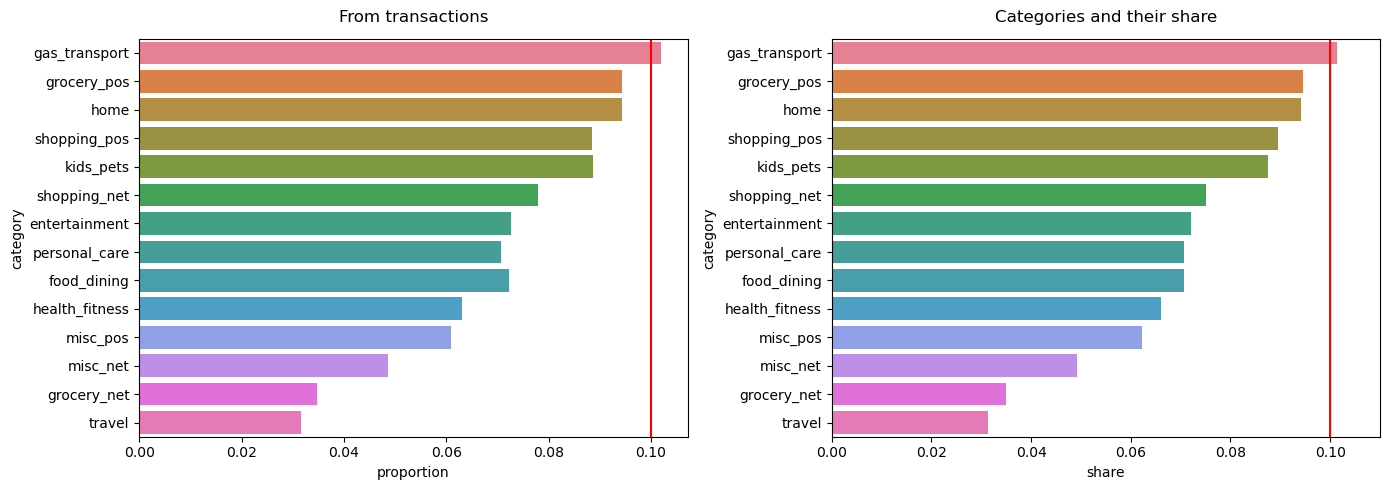

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

sns.barplot(data=cat_props_merged, x="proportion", y="category", hue="category", ax=ax[0])
ax[0].axvline(x=0.1, color="red")
ax[0].set_title("From transactions", pad=12)
sns.barplot(data=cat_props_merged, x="share", y="category", hue="category", ax=ax[1])
ax[1].axvline(x=0.1, color="red")
ax[1].set_title("Categories and their share", pad=12)
ax[1].set_xlim(0, 0.11)
plt.tight_layout();

In [105]:
# Проверка многократным семплированием категорий с переданными весами. 
# Для проверки того что все работает как надо при семплировании

cat_sample_150 = cat_stats_full.category.sample(6000, weights=cat_stats_full.share, replace=True) \
                                .value_counts(normalize=True).reset_index().merge(cat_stats_full, how="left", on="category") \
                                .sort_values("share", ascending=False)

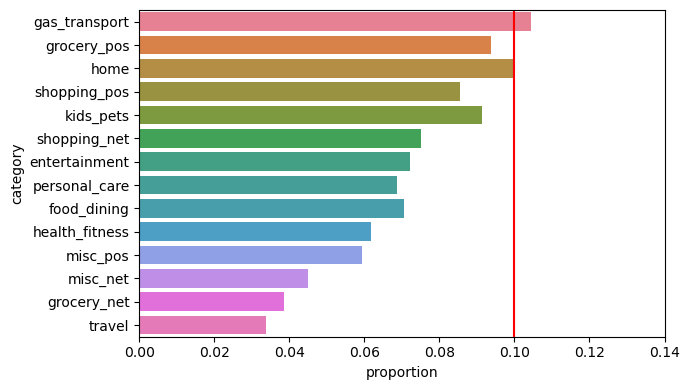

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

sns.barplot(data=cat_sample_150, x="proportion", y="category", hue="category", ax=ax)
ax.axvline(x=0.1, color="red")
ax.set_xlim(0, 0.14)
plt.tight_layout();

**Проверка распределения времени по категориям**

In [107]:
multi_legit_trans_test.head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m
38,375,2025-01-01 01:18:00,1735694280,1463.80513,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,<NA>,False,False,approved,not applicable,NaN,NaN,NaN
7,144,2025-01-01 01:47:00,1735696020,1.00000,purchase,POS,food_dining,False,2505.0,Таганрог,47.241043,38.831282,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN


In [108]:
cat_stats_full.head()

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732,True
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229,True
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280,False
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278,False
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335,False


In [109]:
# джоин флага round clock к транзакциям. для разделения на сабсеты: оффлайн 24 часа, онлайн, оффлайн день

multi_legit_and_cats = multi_legit_trans_test.merge(cat_stats_full[["category", "round_clock"]].copy(), on="category")
multi_legit_and_cats.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
0,375,2025-01-01 01:18:00,1735694280,1463.805130,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
1,144,2025-01-01 01:47:00,1735696020,1.000000,purchase,POS,food_dining,False,2505.0,Таганрог,47.241043,38.831282,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
2,356,2025-01-01 02:52:00,1735699920,1.000000,purchase,ecom,shopping_net,True,6828.0,Москва,55.753879,37.620373,2.60.1.81,613,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
3,335,2025-01-01 04:09:00,1735704540,3716.866118,purchase,ecom,misc_net,True,6900.0,Оренбург,51.787519,55.101738,2.60.1.60,575,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
4,148,2025-01-01 05:17:00,1735708620,2181.456788,purchase,ecom,shopping_net,True,6827.0,Липецк,52.610303,39.594627,2.60.0.139,256,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True


In [110]:
multi_legit_offline_24 = multi_legit_and_cats.query("online == False and round_clock == True")
multi_legit_offline_24.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
1,144,2025-01-01 01:47:00,1735696020,1.000000,purchase,POS,food_dining,False,2505.0,Таганрог,47.241043,38.831282,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
6,158,2025-01-01 06:17:00,1735712220,685.171458,purchase,POS,gas_transport,False,3761.0,Пенза,53.208621,44.958076,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
7,369,2025-01-01 06:18:00,1735712280,1.000000,purchase,POS,misc_pos,False,6717.0,Комсомольск-на-Амуре,50.616142,136.986352,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
9,420,2025-01-01 06:52:00,1735714320,1.000000,purchase,POS,food_dining,False,6267.0,Рязань,54.665771,39.738173,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
10,144,2025-01-01 07:02:00,1735714920,1360.890236,purchase,POS,grocery_pos,False,1652.0,Таганрог,47.246573,38.929530,not applicable,<NA>,<NA>,False,False,approved,not applicable,1.735696e+09,False,315.0,True


In [111]:
multi_legit_online = multi_legit_and_cats.query("online == True")
multi_legit_online.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
0,375,2025-01-01 01:18:00,1735694280,1463.805130,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
2,356,2025-01-01 02:52:00,1735699920,1.000000,purchase,ecom,shopping_net,True,6828.0,Москва,55.753879,37.620373,2.60.1.81,613,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
3,335,2025-01-01 04:09:00,1735704540,3716.866118,purchase,ecom,misc_net,True,6900.0,Оренбург,51.787519,55.101738,2.60.1.60,575,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
4,148,2025-01-01 05:17:00,1735708620,2181.456788,purchase,ecom,shopping_net,True,6827.0,Липецк,52.610303,39.594627,2.60.0.139,256,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True
5,72,2025-01-01 06:16:00,1735712160,1.000000,purchase,ecom,misc_net,True,6859.0,Барнаул,53.348115,83.779836,2.60.0.68,122,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,True


In [112]:
multi_legit_offline_day = multi_legit_and_cats.query("online == False and round_clock == False")
multi_legit_offline_day.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
18,375,2025-01-01 08:09:00,1735718940,134.060405,purchase,POS,shopping_pos,False,2197.0,Тверь,56.822036,35.830530,not applicable,<NA>,<NA>,False,False,approved,not applicable,1.735694e+09,True,411.0,False
19,183,2025-01-01 08:10:00,1735719000,813.951230,purchase,POS,kids_pets,False,1695.0,Москва,55.679595,37.590096,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,False
29,95,2025-01-01 08:40:00,1735720800,1.000000,purchase,POS,health_fitness,False,482.0,Иваново,56.981164,40.982606,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,False
30,361,2025-01-01 08:47:00,1735721220,446.222149,purchase,POS,kids_pets,False,5945.0,Санкт-Петербург,59.942207,30.411543,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,False
39,96,2025-01-01 09:18:00,1735723080,284.863447,purchase,POS,health_fitness,False,5102.0,Санкт-Петербург,59.935492,30.459004,not applicable,<NA>,<NA>,False,False,approved,not applicable,NaN,NaN,NaN,False


In [113]:
# Проверка есть ли транзакции из дневной категории выходящие за установленные пределы по времени
# для этой категории - 08:00-21:59

multi_legit_offline_day.loc[(multi_legit_offline_day.txn_time.dt.hour < 8) | (multi_legit_offline_day.txn_time.dt.hour > 21)]

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock


**Визуализация того, как распределено время транзакций по часам согласно их типу:**<br>
- оффлайн 24 часа, онлайн, дневной оффлайн

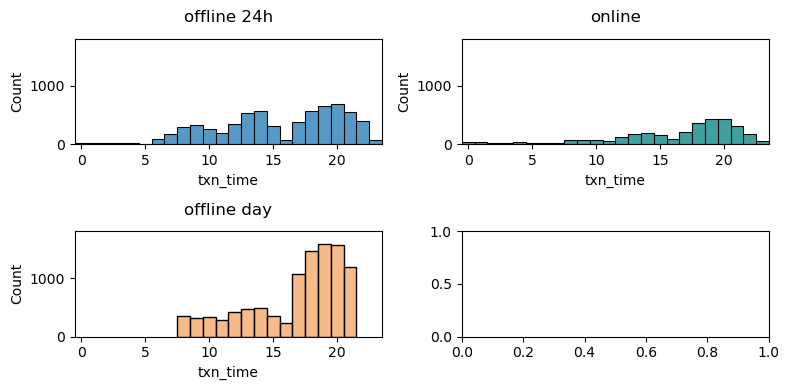

In [114]:
# при необходимости настроить ax.set_ylim() чтобы столбцы помещались в высоту 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,4))
titles = [["offline 24h", "online"], ["offline day"]]

sns.histplot(x=multi_legit_offline_24.txn_time.dt.hour, binwidth=1, discrete=True, ax=axes[0,0])
sns.histplot(x=multi_legit_online.txn_time.dt.hour, binwidth=1, discrete=True, color="teal", ax=axes[0,1])
p = sns.histplot(x=multi_legit_offline_day.txn_time.dt.hour, binwidth=1, discrete=True, color="sandybrown", ax=axes[1,0])

for row, title_pair in zip(axes, titles):
    for ax, title in zip(row, title_pair):
        ax.set_xlim(-0.5, 23.5)
        ax.set_ylim(0, 1800)
        ax.set_title(title, pad=12)
plt.tight_layout()
plt.show()

**Проверка средних сумм транзакций и стандартного отклонения сумм по категориям**

In [115]:
multi_legit_amt_avg_std = multi_legit_trans_test.groupby("category", as_index=False).agg({"amount":["mean","std"]})
multi_legit_amt_avg_std.columns = ["category", "avg_amt_real", "amt_std_real"]
multi_leg_amt_check_merged = multi_legit_amt_avg_std.merge(cat_stats_full[["category", "avg_amt", "amt_std"]], on="category")
multi_leg_amt_check_perc = pd.DataFrame(index=multi_legit_amt_avg_std.index, columns=["category", "avg_change","std_change"])

# Посчитаем на сколько процентов отличаются фактические среднее и стандартное отклонение от образца
multi_leg_amt_check_perc["category"] = multi_legit_amt_avg_std["category"]
multi_leg_amt_check_perc["avg_change"] = multi_leg_amt_check_merged.avg_amt_real.div(multi_leg_amt_check_merged.avg_amt).mul(100).sub(100)
multi_leg_amt_check_perc["std_change"] = multi_leg_amt_check_merged.amt_std_real.div(multi_leg_amt_check_merged.amt_std).mul(100).sub(100)

# Трансформация данных в длинный формат для построения двух графиков в seaborn
multi_leg_amt_check_perc_melt = multi_leg_amt_check_perc.melt(id_vars=["category"], value_vars=["avg_change", "std_change"], \
                                                        value_name="value", var_name="measure")
multi_leg_amt_check_perc_melt.iloc[np.r_[0:3,-3:0]]

,category,measure,value
0,entertainment,avg_change,10.050481
1,food_dining,avg_change,9.377302
2,gas_transport,avg_change,-0.127827
25,shopping_net,std_change,-30.298913
26,shopping_pos,std_change,-29.859251
27,travel,std_change,-38.227752


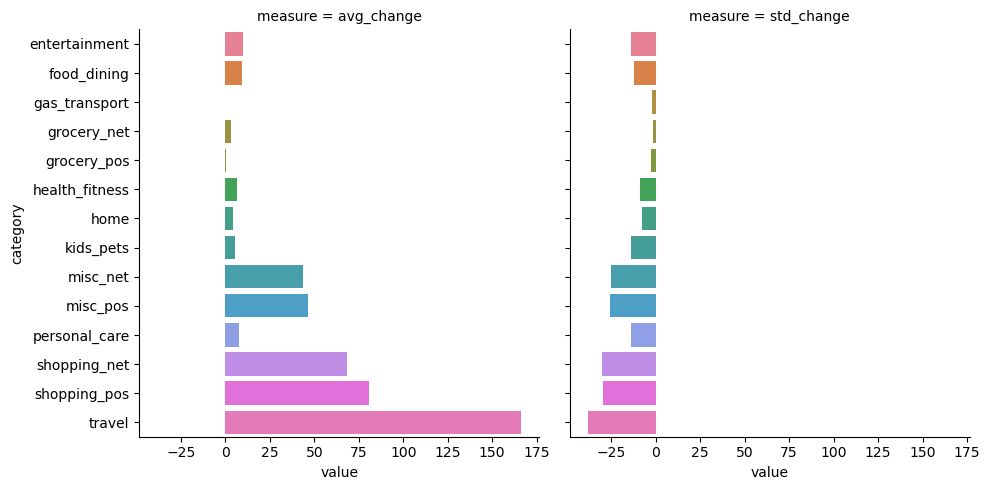

In [116]:
sns.catplot(x="value", y="category", col="measure", hue="category", kind="bar", data=multi_leg_amt_check_perc_melt);

Видимо у категорий у которых большое std, у тех и среднее сильнее отклоняется - имеется в виду график выше.  
Ниже график сравнения отклонений фактического среднего от среднего которое бралось для генерации и  
распределение стандартных отклонений которые использовались при генерации.  
Чтобы посмотреть зависимость  
Сортировка обоих датафреймов по категориям, чтобы было визуальное соответсвие

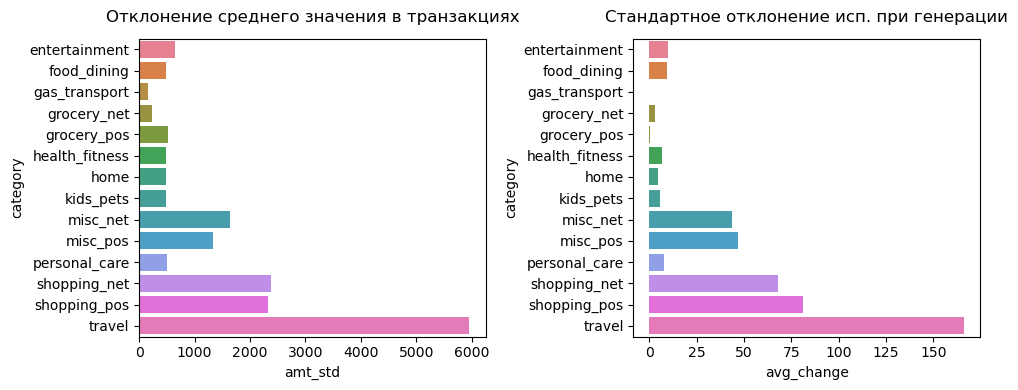

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(data=cat_stats_full[["category","amt_std"]].sort_values("category"), x="amt_std", y="category", \
                                                        hue="category", ax=ax[0])
sns.barplot(data=multi_leg_amt_check_perc.sort_values("category"), x="avg_change", y="category", hue="category", ax=ax[1])

ax[0].set_title("Отклонение среднего значения в транзакциях", pad=12)
ax[1].set_title("Стандартное отклонение исп. при генерации", pad=12)
plt.tight_layout();

**Проверка что города мерчантов совпадают с городами клиентов т.к. это легальные транзакции**

In [118]:
multi_legit_trans_test.merge(offline_merchants, on="merchant_id") \
                    .query("trans_city != area")

,client_id,txn_time,unix_time,amount,type,channel,category_x,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,district_code,region,area,timezone,population,clients,category_y,avg_amt,amt_std,cat_count,merchant_lat,merchant_lon,geometry


**Проверка что id онлайн мерчантов это id только от онлайн мерчантов, без оффлайн**

In [119]:
# Фильтрация по online и инверсия фильтрации по online_merchant_ids
# Если датафрейм на выходе пустой, то нет онлайн транзакций где id мерчанта взят из оффлайн

multi_legit_trans_test[(multi_legit_trans_test.online == True) & ~(multi_legit_trans_test.merchant_id.isin(online_merchant_ids))]

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


In [120]:
# такая же проверка для оффлайн мерчантов

multi_legit_trans_test[(multi_legit_trans_test.online == False) \
& ~(multi_legit_trans_test.merchant_id.isin(offline_merchants.merchant_id))]

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


**Проверка на пустые значения**

In [121]:
# проверка на пустые значения в целом

multi_legit_trans_test.isna().sum()

client_id               0
txn_time                0
unix_time               0
amount                  0
type                    0
channel                 0
category                0
online                  0
merchant_id             0
trans_city              0
trans_lat               0
trans_lon               0
trans_ip                0
device_id           16619
account             19811
is_fraud                0
is_suspicious           0
status                  0
rule                    0
prev_txn_unix         401
prev_online           401
prev_time_diff_m      401
dtype: int64

In [123]:
# проверка на пустые значения для онлайн транзакций
# не должно быть пустых device_id

multi_legit_online_only = multi_legit_trans_test.query("online == True")
multi_legit_online_only.device_id.isna().any()

np.False_

In [124]:
# Есть ли онлайн транзакции где нет IP адреса

multi_legit_online_only.query("trans_ip == 'not applicable'")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m


**Проверка правильности генерации девайсов клиентов**

In [126]:
# Джоин таблицы с девайсами к таблице транзакций по device_id

multi_legit_devices = multi_legit_online_only.merge(client_devices, on="device_id").copy() \
                                            .drop(columns=['account', 'is_fraud', 'is_suspicious', 'status', \
                                                           'rule', 'prev_txn_unix', 'prev_online', 'prev_time_diff_m'])
multi_legit_devices.head()

,client_id_x,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,client_id_y,platform
0,375,2025-01-01 01:18:00,1735694280,1463.805130,purchase,ecom,shopping_net,True,6825.0,Тверь,56.858540,35.911790,2.60.1.100,649,375,Android
1,356,2025-01-01 02:52:00,1735699920,1.000000,purchase,ecom,shopping_net,True,6828.0,Москва,55.753879,37.620373,2.60.1.81,613,356,Android
2,335,2025-01-01 04:09:00,1735704540,3716.866118,purchase,ecom,misc_net,True,6900.0,Оренбург,51.787519,55.101738,2.60.1.60,575,335,Windows
3,148,2025-01-01 05:17:00,1735708620,2181.456788,purchase,ecom,shopping_net,True,6827.0,Липецк,52.610303,39.594627,2.60.0.139,256,148,macOS
4,72,2025-01-01 06:16:00,1735712160,1.000000,purchase,ecom,misc_net,True,6859.0,Барнаул,53.348115,83.779836,2.60.0.68,122,72,macOS


In [127]:
# Проверка где device_id взят от другого клиента

multi_legit_devices.query("client_id_x != client_id_y")

,client_id_x,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,client_id_y,platform


**Распределение платформ в транзакциях**

In [128]:
# Распределение в транзакциях

multi_legit_platforms = multi_legit_devices.platform.value_counts(normalize=True).reset_index()
multi_legit_platforms

,platform,proportion
0,Android,0.451441
1,Windows,0.317669
2,iOS,0.092105
3,macOS,0.088972
4,Linux,0.049812


In [129]:
# Распределение у клиентов

client_platforms_share = client_devices.platform.value_counts(normalize=True).reset_index()
client_platforms_share

,platform,proportion
0,Android,0.444456
1,Windows,0.325078
2,macOS,0.094301
3,iOS,0.084352
4,Linux,0.051813


In [130]:
# Сверка

multi_legit_platforms.merge(client_platforms_share, on="platform", suffixes = ("_fact","_src"))

,platform,proportion_fact,proportion_src
0,Android,0.451441,0.444456
1,Windows,0.317669,0.325078
2,iOS,0.092105,0.084352
3,macOS,0.088972,0.094301
4,Linux,0.049812,0.051813


**Сверка корректности IP адресов**

In [131]:
# Джоин по IP адресам. И проверка есть ли несоответсвие client_id - не получил ли клиент чужой IP для транзакции

multi_legit_online_only.merge(clients_with_geo, left_on="trans_ip", right_on="home_ip").query("client_id_x != client_id_y")

,client_id_x,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,client_id_y,district_id,birth_date,sex,region,area,timezone,lat,lon,population,home_ip,geometry


# Генерация транзакций частями и запись в `parquet`
См. Запись транзакций чанками в файлы - GPT

**Проверка записи-чтения в parquet**

In [132]:
multi_legit_trans_test_orig.to_parquet("./data/generated_data/multiple_legit_test.parquet", engine="pyarrow")

In [133]:
multi_legit_parquet = pd.read_parquet("./data/generated_data/multiple_legit_test.parquet", engine="pyarrow")

In [134]:
multi_legit_parquet.shape

(19811, 19)

In [135]:
multi_legit_parquet.dtypes

client_id                 int64
txn_time         datetime64[ns]
unix_time                 int64
amount                  float64
type                     object
channel                  object
category                 object
online                     bool
merchant_id             float64
trans_city               object
trans_lat               float64
trans_lon               float64
trans_ip                 object
device_id               float64
account                  object
is_fraud                   bool
is_suspicious              bool
status                   object
rule                     object
dtype: object

**Семплирование клиентов из главного датафрейма с клиентами**
- Т.к. транзакции будут сгенерированы не на всех клиентов из-за небыстрой генерации

In [176]:
# Равномерное семплирование 3000 клиентов

clients_sample_df = clients_with_geo.sample(n=3000).reset_index(drop=True)

In [ ]:
clients_sample_df.to_file("./data/cleaned_data/clients_sample.gpkg")

In [177]:
# сколько городов в семплированном датафрейме. Максимум - 77

clients_sample_df["area"].nunique()

77

**Квантили частей датафрейма с клиентами**  
нужны для разделения датафрейма на части, чтобы генерировать не разом для всех, а по частям. И части записывать в файлы  
Потом из файлов собирать в целый датафрейм  
Делить будем по индексу  
1. Создадим датафрейм с границами чанков в виде значений индекса
2. Будем итерироваться через этот датафрейм и брать значения индекса и по этим значениям брать сабсет клиентов для генерации.
3. Для сабсета клиентов генерируем транзакции и записываем в файл


In [178]:
# Квантили для каждых 500 значений из 3000
quantile_bounds = np.array(range(0, 3500, 500)) / 3000
# quantile_bounds = np.array(range(0, 1400, 200)) / 1200
quantile_bounds

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [179]:
# Берем значения индексов для каждого квантиля

clients_index_chunks = clients_sample_df.index.copy().to_series().quantile(quantile_bounds).reset_index() \
                                        .rename(columns={0:"lower_bound"}).drop(columns="index")

In [180]:
# в колонке upper_bound верхняя граница чанка. Но надо отнять 1 от верхней границы, 
# кроме последнего чанка, чтобы не было дублирования. Также округляем нецелые числа в меньшую сторону в обоих колонках
clients_index_chunks["upper_bound"] = clients_index_chunks["lower_bound"].shift(-1).sub(1).apply(np.floor)
# делаем значение верхней границы последнего чанка прежним
clients_index_chunks.loc[5, "upper_bound"] += 1 
clients_index_chunks["lower_bound"] = clients_index_chunks["lower_bound"].apply(np.floor)
clients_index_chunks = clients_index_chunks.drop(index=6).astype({"lower_bound":"int", "upper_bound":"int"})
clients_index_chunks

,lower_bound,upper_bound
0,0,498
1,499,998
2,999,1498
3,1499,1998
4,1999,2498
5,2499,2999


In [181]:
# Размеры чанков ~500

clients_index_chunks["upper_bound"] - clients_index_chunks["lower_bound"]

0    498
1    499
2    499
3    499
4    499
5    500
dtype: int64

**Проверка что не теряем клиентов и нет ошибок при разделении на намеченные чанки**

In [182]:
client_chunks_test = defaultdict(pd.DataFrame)

In [183]:
# Запишем чанки в словарь

for row in clients_index_chunks.itertuples():
    chunk_num = row.Index + 1
    client_chunks_test[f"chunk_{chunk_num:04d}"] = clients_with_geo.loc[row.lower_bound:row.upper_bound]
    

In [184]:
# Соберем чанки обратно в единый датафрейм. Проверим размеры чанков и итогового датафрейма

total_length = 0
clients_fm_chunks = [pd.DataFrame(columns=clients_with_geo.columns)]

for chunk in client_chunks_test.values():
    print(chunk.shape)
    total_length += chunk.shape[0]
    clients_fm_chunks.append(chunk)

print(total_length)
clients_fm_chunks = pd.concat(clients_fm_chunks, ignore_index=True)
clients_fm_chunks.head()

(499, 12)
(500, 12)
(500, 12)
(500, 12)
(500, 12)
(501, 12)
3000


C:\Users\iaros\AppData\Local\Temp\ipykernel_7708\2559239104.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clients_fm_chunks = pd.concat(clients_fm_chunks, ignore_index=True)


,client_id,district_id,birth_date,sex,region,area,timezone,lat,lon,population,home_ip,geometry
0,1,18,1970-12-13,female,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,2.60.0.1,"MULTIPOLYGON (((39.53667 54.6385, 39.53677 54...."
1,2,1,1945-02-04,male,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.2,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
2,3,1,1940-10-09,female,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.3,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
3,4,5,1956-12-01,male,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.4,"MULTIPOLYGON (((39.47099 47.20487, 39.48381 47..."
4,5,5,1960-07-03,female,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.5,"MULTIPOLYGON (((39.47099 47.20487, 39.48381 47..."


In [185]:
# Проверка на дубликаты в собранном датафрейме

clients_fm_chunks.drop_duplicates(subset="client_id").shape

(3000, 12)

**Генерация чанков и запись в файлы**

In [3]:
timestamps = create_timestamps_range_df(start="2025-01-01", end="2025-01-31")
# Он тут не играет роли, т.к. генерируем всего за месяц. Но это задел для случаев когда взят период более одного месяца
timestamps_1st_month = timestamps.loc[timestamps.timestamp.dt.month == timestamps.timestamp.dt.month.min()].copy()

NameError: name 'create_timestamps_range_df' is not defined

In [ ]:
timestamps.to_parquet("./data/generated_data/timestamps.parquet", engine="pyarrow")

In [187]:
time_weights_dict = get_all_time_patterns(time_weight_args)

In [209]:
trans_df = transactions.copy()
trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule


In [219]:
%%time
for row in clients_index_chunks.itertuples():
    clients_subset = clients_sample_df.loc[row.lower_bound:row.upper_bound]
    trans_df = transactions.copy()
    chunk_num = row.Index + 1
    
    chunk = gen_multiple_legit_trans(clients_df=clients_subset, trans_df=trans_df, client_devices=client_devices, \
                                                  offline_merchants=offline_merchants, timestamps=timestamps, \
                                                  timestamps_1st_month=timestamps_1st_month, \
                                                 categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
                                                  time_weights_dict=time_weights_dict)

    print(f"Chunk #{chunk_num}")
    # Запись чанка в файл с название по типу legit_000.parquet
    chunk.to_parquet(f"./data/generated_data/legit_{chunk_num:03d}.parquet", engine="pyarrow")

  1%|          | 24/3000 [09:12<19:01:57, 23.02s/it]


Chunk #1
Chunk #2
Chunk #3
Chunk #4
Chunk #5
Chunk #6
CPU times: total: 19min 45s
Wall time: 20min 5s


In [720]:
# поменять префикс названий файлов

# for file in os.listdir("./data/generated_data/"):
#     new_name = "legit_" + file.split("_")[-1]
#     os.rename("./data/generated_data/" + file, "./data/generated_data/" + new_name)

# os.listdir("./data/generated_data/")

**Чтение чанков и сборка в единый датафрейм** - `legit`

In [221]:
# Записанные чанки
generated_data_dir = "./data/generated_data/"
os.listdir(generated_data_dir)

['legit_001.parquet',
 'legit_002.parquet',
 'legit_003.parquet',
 'legit_004.parquet',
 'legit_005.parquet',
 'legit_006.parquet']

In [222]:
generated_legit_files = os.listdir(generated_data_dir)
all_legit_chunks = []

for file in generated_legit_files:
    path_to_chunk = os.path.join(generated_data_dir, file)
    legit_chunk_df = pd.read_parquet(path_to_chunk, engine="pyarrow")
    all_legit_chunks.append(legit_chunk_df)

legit_trans = pd.concat(all_legit_chunks, ignore_index=True)

In [223]:
legit_trans.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,2867,2025-01-19 12:24:00,1737289440,3629.799233,purchase,ecom,shopping_net,True,6934.0,Москва,55.753879,37.620373,2.60.10.152,4856.0,None,False,False,approved,not applicable
1,2867,2025-01-04 19:04:00,1736017440,1.000000,purchase,POS,home,False,4239.0,Москва,55.866893,37.418088,not applicable,NaN,None,False,False,approved,not applicable
2,2867,2025-01-23 07:48:00,1737618480,404.853890,purchase,POS,misc_pos,False,857.0,Москва,55.536501,37.477297,not applicable,NaN,None,False,False,approved,not applicable
3,2867,2025-01-03 18:08:00,1735927680,1207.546442,purchase,POS,personal_care,False,3393.0,Москва,55.704295,37.669348,not applicable,NaN,None,False,False,approved,not applicable
4,2867,2025-01-16 21:39:00,1737063540,1152.416306,purchase,POS,grocery_pos,False,1696.0,Москва,55.811621,37.800338,not applicable,NaN,None,False,False,approved,not applicable


In [224]:
legit_trans.shape

(147993, 19)

In [225]:
# проверка уникальности записей. Пара client_id и unix_time будут уникальными

legit_trans[["client_id", "unix_time"]].value_counts().shape

(147993,)

In [226]:
legit_trans.dtypes

client_id                 int64
txn_time         datetime64[ns]
unix_time                 int64
amount                  float64
type                     object
channel                  object
category                 object
online                     bool
merchant_id             float64
trans_city               object
trans_lat               float64
trans_lon               float64
trans_ip                 object
device_id               float64
account_to               object
is_fraud                   bool
is_suspicious              bool
status                   object
rule                     object
dtype: object

In [174]:
# 59K транзакций с 1000 клиентов в parquet

# legit_trans.to_parquet("./data/generated_data/legit_trans_50K.parquet", engine="pyarrow")

In [227]:
# 148K транзакций с 3000 клиентов в parquet

legit_trans.to_parquet("./data/generated_data/legit_trans_148K.parquet", engine="pyarrow")

In [229]:
# pd.read_parquet("./data/generated_data/legit_trans_148K.parquet", engine="pyarrow")

In [231]:
legit_trans.groupby("client_id").agg({"unix_time":"count"}).rename(columns={"unix_time":"trans_count"}).agg(["min","max"])

,trans_count
min,4
max,82


In [735]:
# import cProfile

In [736]:
# clients_100 = clients_with_geo[:100].copy()

In [737]:
# trans_for_profile = transactions.copy()

In [734]:
# cProfile.run("""gen_multiple_legit_trans(clients_df=clients_100, trans_df=trans_for_profile, client_devices=client_devices, \
#                                                   offline_merchants=offline_merchants, timestamps=timestamps, \
#                                                   timestamps_1st_month=timestamps_1st_month, \
#                                                  categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
#                                                   time_weights_dict=time_weights_dict)""")

         62479729 function calls (61327738 primitive calls) in 71.822 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4985    0.012    0.000    0.012    0.000 1028514059.py:1(build_transaction)
      173    0.009    0.000    0.009    0.000 1323426738.py:1(pd_timestamp_to_unix)
        1    0.353    0.353   71.818   71.818 1480622854.py:1(gen_multiple_legit_trans)
     4985    0.128    0.000   40.047    0.008 2313945978.py:1(get_time_for_trans)
      100    0.003    0.000    0.199    0.002 2911961910.py:1(sample_time_for_trans)
      100    0.001    0.000    0.049    0.000 3202737387.py:1(gen_trans_number_norm)
     4985    0.098    0.000    6.663    0.001 331495167.py:1(get_txn_location_and_merchant)
     4885    0.308    0.000   29.181    0.006 3362071607.py:1(check_min_interval_from_near_trans)
     4885    0.237    0.000   29.419    0.006 3511359992.py:1(handle_legit_case_time)
     4985    0.277    0.000   49.316  